# <center> Lyapunov Exponent of Lorenz Attractor 
    
**Group B** 
    
PH567- Nonlinear Dynamics Course Project


# Import Packages

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import time, math
from functions import *

# Define ODEs of the system

In [2]:
def xdot(x, t, sigma=16, r=45.92, b=4):
    """
    x is 3D
    Here, dynamical system describing the lorenz attractor is defined
    **Change this to any other attractor you wish to simulate**
    """
    x0dot = sigma*(x[1]-x[0])
    x1dot = x[0]*(r-x[2])-x[1]
    x2dot = x[0]*x[1]-b*x[2]
    xdot = np.array([x0dot, x1dot, x2dot])
    
    return xdot

# All Parameters

**Simulation parameters- timestep, start and end times**

In [3]:
dt = 0.01 #timestep
tstart = 0
tend = 200 #final time


***Parameters of reconstructed phase space***

In [4]:
tau = 8 # delay
m = 3 # dimension of reconstructed phase space

In [5]:
nsteps_display = 5000 # number of time steps used to display plots of actual and reconstructed phase space

**Parameters for visualization of fiducial trajectory, nearby trajectory**

In [6]:
fidloc_visualize = 50 #starting location
numsteps_visualize = 500 #number of time steps

**Parameters for computation of lyapunov exponent**

In [7]:
fidloc = 0 #starting location- to avoid transient
tevol = 120 #number of timesteps in fixed evolution time algorithm
dmin = 2.5 # to obtain nearby trajectory and replacement point
anglemax = 2 # max angle allowed, radians

# Numerical Integration using odeint function

In [8]:
t = np.arange(tstart, tend, dt) #the time axis
T = len(t) #number of timepoints

np.random.seed(0)
y0 = np.random.rand(3,) #initial point

y_t = odeint(xdot, y0, t) #simulate the dynamical system

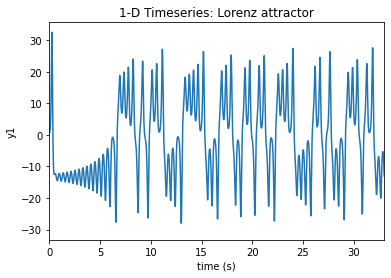

In [9]:
plt.plot(t, y_t[:,0])
plt.xlim(0,33)
plt.xlabel('time (s)')
plt.ylabel('y1')
plt.title('1-D Timeseries: Lorenz attractor')
plt.show()

# Obtain Reconstructed Phase Space with Delayed Coordinates

New delayed coordinates: $ (y_1(t), y_1(t+\tau), y_1(t+2\tau), ..., y_1(t+(m-1)\tau )$

In [10]:
y1_t = y_t[:,0] #observations
yd = reconstructed_phase_space(y1_t, tau, m)

**Visualize Actual and Reconstructed Phase Space**

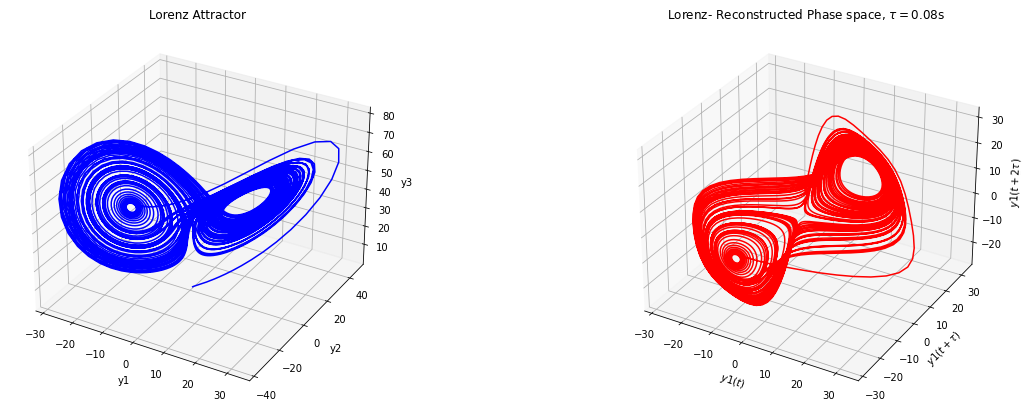

In [11]:
fig = plt.figure(figsize = (20, 7))


ax0=fig.add_subplot(1,2,2,projection='3d')
ax0.plot(yd[:nsteps_display,0],yd[:nsteps_display,1],yd[:nsteps_display,2], color = "Red")
ax0.set_xlabel(r'$y1(t)$')
ax0.set_ylabel(r'$y1(t+\tau)$')
ax0.set_zlabel(r'$y1(t+2\tau)$')
ax0.set_title(r"Lorenz- Reconstructed Phase space, $\tau=$"+str(tau*dt)+'s')

ax1=fig.add_subplot(1,2,1,projection='3d')
ax1.plot(y_t[:nsteps_display,0],y_t[:nsteps_display,1],y_t[:nsteps_display,2], color = "blue")
ax1.set_title("Lorenz Attractor")
ax1.set_xlabel('y1')
ax1.set_ylabel('y2')
ax1.set_zlabel('y3')

plt.show()

Fiducial Trajectory- $yd[0,:]$ to $yd[-1,:]$

# Observe fiducial trajectory and a nearby trajectory

index of starting point=50, index of closest point=209
distance to closest point (dmin=1): 1.0296808038383494


Text(0.5, 0.92, 'Fiducial & nearby trajectory evolution')

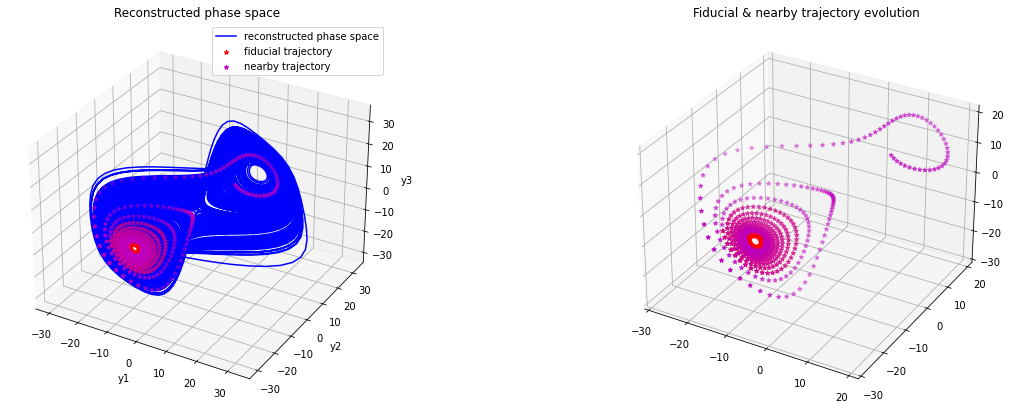

In [12]:
clos = closest_point(fidloc_visualize, yd, dmin=1)
print(f"index of starting point={fidloc_visualize}, index of closest point={clos}")
print(f"distance to closest point (dmin=1): {np.linalg.norm(yd[fidloc_visualize,:]-yd[clos,:])}")


fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(1, 2, 1, projection='3d')

clos_pair = np.concatenate((np.expand_dims(yd[fidloc_visualize:fidloc_visualize+numsteps_visualize,:], axis=2), np.expand_dims(yd[clos:clos+numsteps_visualize,:], axis=2)), axis=2)

ax.scatter(clos_pair[:,0,0], clos_pair[:,1,0], clos_pair[:,2,0], marker='*', color=['r'])
ax.scatter(clos_pair[:,0,1], clos_pair[:,1,1], clos_pair[:,2,1], marker='*', color=['m'])

ax.plot(yd[:,0],yd[:,1],yd[:,2], color = "blue")
ax.set_title("Reconstructed phase space")
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('y3')
ax.legend(['reconstructed phase space', 'fiducial trajectory', 'nearby trajectory'])

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(clos_pair[:,0,0], clos_pair[:,1,0], clos_pair[:,2,0], marker='*', color=['r'])
ax2.scatter(clos_pair[:,0,1], clos_pair[:,1,1], clos_pair[:,2,1], marker='*', color=['m'])
ax2.set_title("Fiducial & nearby trajectory evolution")

Text(0.5, 1.0, '$||\\delta||$ vs t (log scale)')

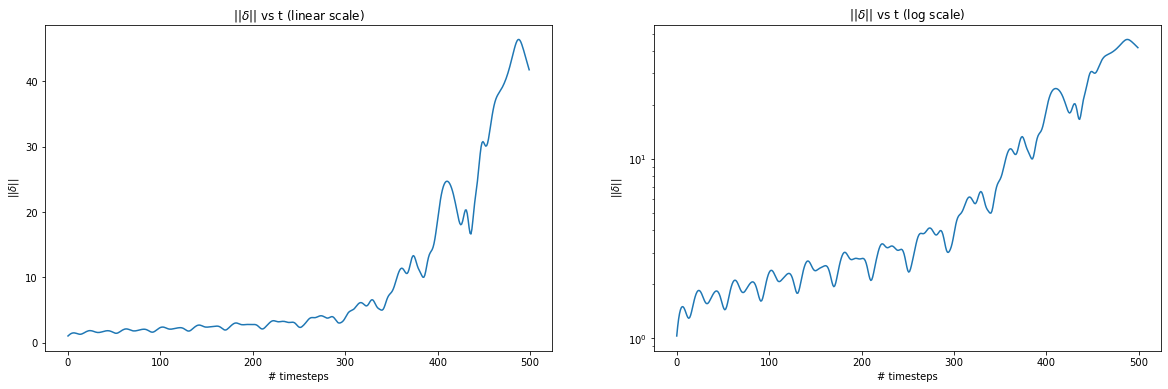

In [13]:
lengths = np.linalg.norm(yd[fidloc_visualize:fidloc_visualize+numsteps_visualize,:]-yd[clos:clos+numsteps_visualize,:], axis=1)
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(lengths)
# plt.yscale('log')
ax[0].set_xlabel('# timesteps')
ax[0].set_ylabel(r'$||\delta||$')
ax[0].set_title(r"$||\delta||$ vs t (linear scale)")

ax[1].plot(lengths)
ax[1].set_yscale('log')
ax[1].set_xlim()
ax[1].set_xlabel('# timesteps')
ax[1].set_ylabel(r'$||\delta||$')
ax[1].set_title(r"$||\delta||$ vs t (log scale)")

Observations:
1. The plot of separation as a function of time shows exponential behaviour, although with some jitter.

# Computing Lyapunov Exponents 

***Choose parameters:***

In [14]:
lamAll, local_lam, lengthsAll, lengthsInit, lengthsFinal = compute_lambda(yd, t, fidloc, tevol, dmin, anglemax) #using actual phase space
niter = len(lamAll)
# plt.plot(lamAll)

Text(0, 0.5, '$||\\delta||$ (log scale)')

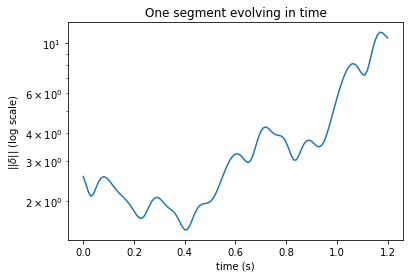

In [15]:
id_len = 20 #observations: from 0-200, lengths are either oscillating or decreasing. after 200, lengths are increasing
plt.plot(t[[i for i in range(tevol+1)]],lengthsAll[id_len])
plt.yscale('log')
plt.title(f"One segment evolving in time")
plt.xlabel("time (s)")
plt.ylabel(r"$||\delta||$ (log scale)")

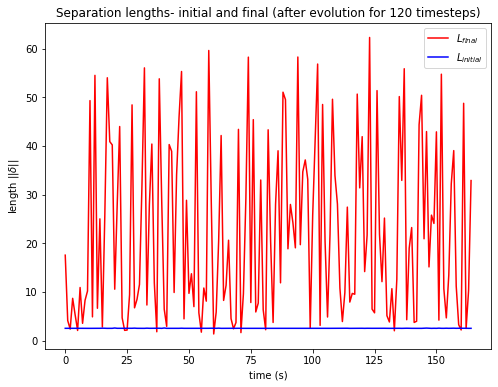

In [16]:
fig = plt.figure(figsize=(8,6))
plt.plot(lengthsFinal,'r')
plt.plot(lengthsInit, 'b')
plt.title(f"Separation lengths- initial and final (after evolution for {tevol} timesteps)")
plt.xlabel("time (s)")
plt.ylabel(r"length $||\delta||$")
plt.legend([r'$L_{final}$',r'$L_{initial}$'])

# Local lyapunov exponent

Text(0.5, 1.0, 'Local lyapunov exponent vs time')

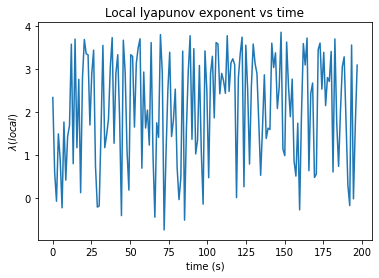

In [17]:
plt.plot(t[[i*tevol for i in range(niter)]],local_lam)
plt.xlabel("time (s)")
plt.ylabel(r'$\lambda (local)$')
plt.title("Local lyapunov exponent vs time")

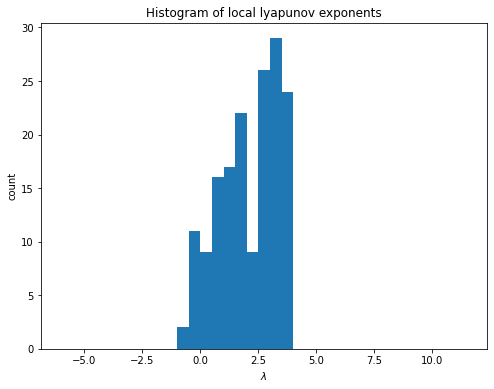

In [18]:
fig = plt.figure(figsize=(8,6))
plt.hist(local_lam, bins=[0.5*i for i in range(-12,24)])
plt.title(f"Histogram of local lyapunov exponents")
plt.ylabel("count")
plt.xlabel(r"$\lambda$")
plt.show()

Compute and plot $\lambda$

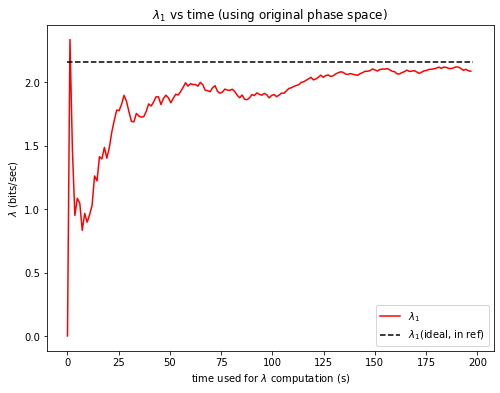

In [19]:
fig = plt.figure(figsize=(8,6))
plt.plot(t[:niter*tevol:tevol],lamAll, 'r-')
plt.xlabel(r'time used for $\lambda$ computation (s)')
plt.ylabel(r'$\lambda$ (bits/sec)')
plt.title(r'$\lambda_1$ vs time (using original phase space) ')
# plt.xlim(0, 40)
# plt.ylim(-3, 10)
plt.plot([0, t[niter*tevol]], [2.16,2.16], 'k--')

plt.legend([r'$\lambda_1$',r'$\lambda_1$(ideal, in ref)'])

In [20]:
print(np.mean(lamAll[-50:]))

2.094202768599166


In [21]:
print(lamAll[-1])

2.0888511971833745


**$\lambda\approx2.09$** is obtained, which is close to $\lambda_{actual}=2.16$ (error of 3%)

# Recurrence Plots

In [22]:
Np = 500

In [23]:
RecurrencePlot = np.zeros((Np, Np))

In [24]:
tic = time.time()
for i in range(Np):
    for j in range(Np):
        RecurrencePlot[i,j] = np.linalg.norm(yd[i,:]- yd[j,:])
        
print(f"time taken={time.time()-tic}s")

time taken=2.0306453704833984s


Text(0.5, 1.0, 'Recurrence Plot: Lorenz Attractor with 500 points')

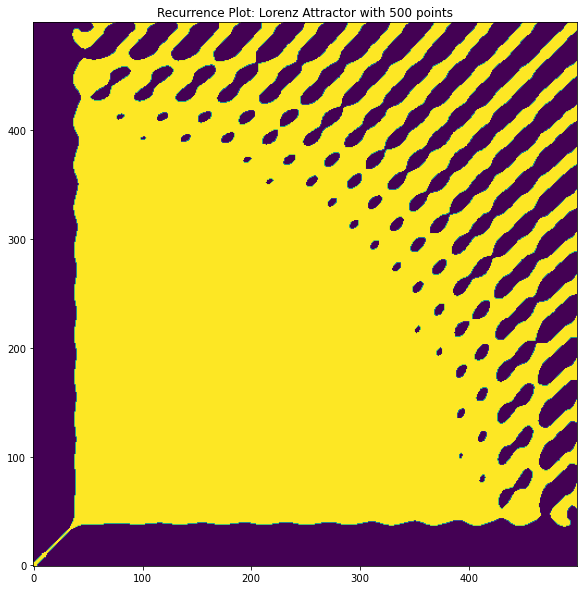

In [25]:
thr = 7
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(RecurrencePlot<thr, origin='lower')
ax.set_title(f"Recurrence Plot: Lorenz Attractor with {Np} points")

In [26]:
rp_bin = (RecurrencePlot<thr).astype('float')

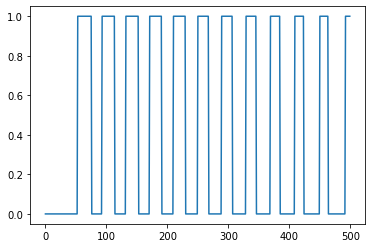

In [27]:
plt.plot(rp_bin[:,-1])

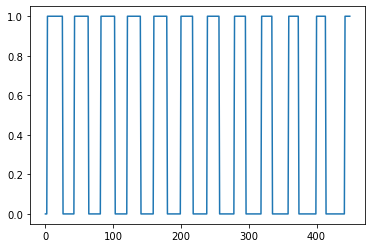

In [28]:
plt.plot(rp_bin[50:,-1])

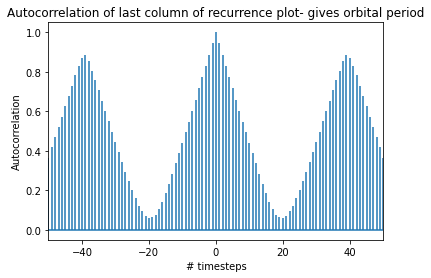

In [29]:
plt.acorr(rp_bin[:,-1], maxlags=100)
plt.xlim(-50,50)
plt.title("Autocorrelation of last column of recurrence plot- gives orbital period")
plt.xlabel("# timesteps")
plt.ylabel("Autocorrelation")
plt.show()

It is clear that the orbital period is nearly 40 timesteps, i.e., **orbital period=0.4s**